In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [152]:
from sklearn.datasets import fetch_20newsgroups
categories = ['rec.sport.baseball',
               'sci.electronics',
              'sci.space', ]
newsgroups = fetch_20newsgroups(categories=categories)
y_true = newsgroups.target

In [153]:
df = pd.DataFrame(newsgroups.data)

In [25]:
import nltk

In [27]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

In [33]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adithiloka/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [68]:
#nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [lemmatizer.lemmatize(token) for token in doc.split() if token not in stopwords.words('english')]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)
#     else:
#         return txt

In [155]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df[0])

In [156]:
t = time()

txt = [cleaning(doc) for doc in brief_cleaning]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.06 mins


In [157]:
len(txt)

1781

In [158]:
df_clean = pd.DataFrame({'clean': pd.Series(txt)})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1780, 1)

In [159]:
from gensim.models.phrases import Phrases, Phraser
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)


INFO - 02:21:50: collecting all words and their counts
INFO - 02:21:50: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 02:21:51: collected 176108 token types (unigram + bigrams) from a corpus of 270547 words and 1780 sentences
INFO - 02:21:51: merged Phrases<176108 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 02:21:51: Phrases lifecycle event {'msg': 'built Phrases<176108 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.39s', 'datetime': '2021-04-18T02:21:51.111543', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'created'}


In [160]:
bigram = Phraser(phrases)
sentences = bigram[sent]

INFO - 02:21:53: exporting phrases from Phrases<176108 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 02:21:54: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<201 phrases, min_count=30, threshold=10.0> from Phrases<176108 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.48s', 'datetime': '2021-04-18T02:21:54.396173', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'created'}


In [161]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:10]


['edu',
 'subject',
 'organization',
 'would',
 'one',
 'line',
 'space',
 'com',
 'writes',
 'year']

In [77]:
import multiprocessing

from gensim.models import Word2Vec

In [78]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [162]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

INFO - 02:22:05: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.03)', 'datetime': '2021-04-18T02:22:05.702049', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'created'}


In [163]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 02:22:09: collecting all words and their counts
INFO - 02:22:09: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 02:22:09: collected 22048 word types from a corpus of 259549 raw words and 1780 sentences
INFO - 02:22:09: Creating a fresh vocabulary
INFO - 02:22:09: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 2596 unique words (11.774310595065312%% of original 22048, drops 19452)', 'datetime': '2021-04-18T02:22:09.735524', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 02:22:09: Word2Vec lifecycle event {'msg': 'effective_min_count=20 leaves 190361 word corpus (73.34299111150496%% of original 259549, drops 69188)', 'datetime': '2021-04-18T02:22:09.736414', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64

Time to build vocab: 0.01 mins


In [164]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 02:22:19: Word2Vec lifecycle event {'msg': 'training model with 11 workers on 2596 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2', 'datetime': '2021-04-18T02:22:19.141896', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'train'}
INFO - 02:22:19: worker thread finished; awaiting finish of 10 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 9 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 8 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 7 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 6 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 5 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 4 more threads
INFO - 02:22:19: worker thread finished; awaiting finish of 3 more threads
INFO - 02:22

INFO - 02:22:23: worker thread finished; awaiting finish of 6 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 5 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 4 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 3 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 2 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 1 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 0 more threads
INFO - 02:22:23: EPOCH - 9 : training on 259549 raw words (93834 effective words) took 0.5s, 194712 effective words/s
INFO - 02:22:23: worker thread finished; awaiting finish of 10 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 9 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 8 more threads
INFO - 02:22:23: worker thread finished; awaiting finish of 7 more threads
INFO - 02:22:23: worker thread finished; awaiting finish

INFO - 02:22:26: worker thread finished; awaiting finish of 10 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 9 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 8 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 7 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 6 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 5 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 4 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 3 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 2 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 1 more threads
INFO - 02:22:26: worker thread finished; awaiting finish of 0 more threads
INFO - 02:22:26: EPOCH - 18 : training on 259549 raw words (93853 effective words) took 0.4s, 229191 effective words/s
INFO - 02:22:27: worker thread finished; awaiting finis

INFO - 02:22:30: worker thread finished; awaiting finish of 1 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 0 more threads
INFO - 02:22:30: EPOCH - 26 : training on 259549 raw words (93709 effective words) took 0.4s, 228786 effective words/s
INFO - 02:22:30: worker thread finished; awaiting finish of 10 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 9 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 8 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 7 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 6 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 5 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 4 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 3 more threads
INFO - 02:22:30: worker thread finished; awaiting finish of 2 more threads
INFO - 02:22:30: worker thread finished; awaiting finis

Time to train the model: 0.21 mins


In [165]:
w2v_model.init_sims(replace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  """Entry point for launching an IPython kernel.
WARNING - 02:22:36: destructive init_sims(replace=True) deprecated & no longer required for space-efficiency


In [166]:
w2v_model.wv.most_similar(positive=["space"])

[('policy', 0.8428725600242615),
 ('topic', 0.8370314836502075),
 ('moscow', 0.8285248279571533),
 ('aviation', 0.8251315355300903),
 ('agency', 0.8090713620185852),
 ('related', 0.7802411317825317),
 ('russian', 0.7790402173995972),
 ('foundation', 0.7721532583236694),
 ('aerospace', 0.7689868211746216),
 ('european', 0.7623913288116455)]

In [89]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=5).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

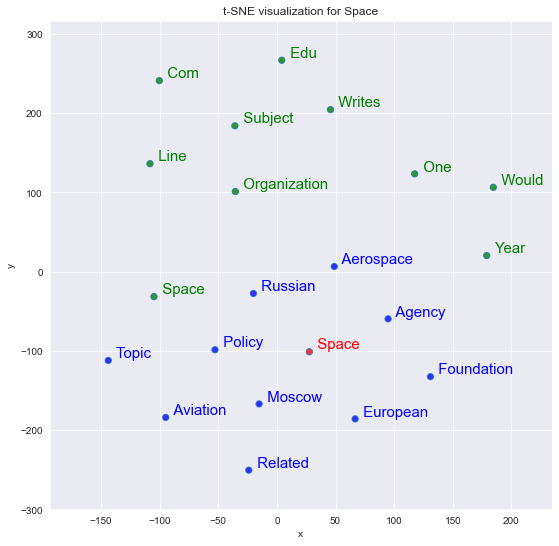

In [167]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
tsnescatterplot(w2v_model, 'space', ['edu',
 'subject',
 'organization',
 'would',
 'one',
 'line',
 'space',
 'com',
 'writes',
 'year'])

In [168]:
from gensim.models import KeyedVectors
word_vectors = w2v_model.wv
word_vectors.save("word2vec.wordvectors")
# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['computer']  # Get numpy vector of a word

INFO - 02:23:48: KeyedVectors lifecycle event {'fname_or_handle': 'word2vec.wordvectors', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-04-18T02:23:48.558327', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'saving'}
INFO - 02:23:48: saved word2vec.wordvectors
INFO - 02:23:48: loading KeyedVectors object from word2vec.wordvectors
INFO - 02:23:48: KeyedVectors lifecycle event {'fname': 'word2vec.wordvectors', 'datetime': '2021-04-18T02:23:48.591729', 'gensim': '4.0.1', 'python': '3.7.7 (default, Mar 10 2020, 15:43:33) \n[Clang 11.0.0 (clang-1100.0.33.17)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'loaded'}


In [169]:
corpus = [i['clean'].split() for _,i in df_clean.iterrows()]

In [171]:
corpus = [item for sublist in corpus for item in sublist]


In [172]:
corpus_vectors = [wv[i] for i in corpus if i in wv]

In [180]:
corpus = [i for i in corpus if i in wv]

In [173]:
len(corpus_vectors)

196058

In [174]:
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 3
data = corpus_vectors

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

In [175]:
from collections import Counter
Counter(assigned_clusters)

Counter({2: 54067, 1: 78393, 0: 63598})

In [181]:
len(corpus)

196058

In [179]:
len(assigned_clusters)

196058

63598
78393
54067


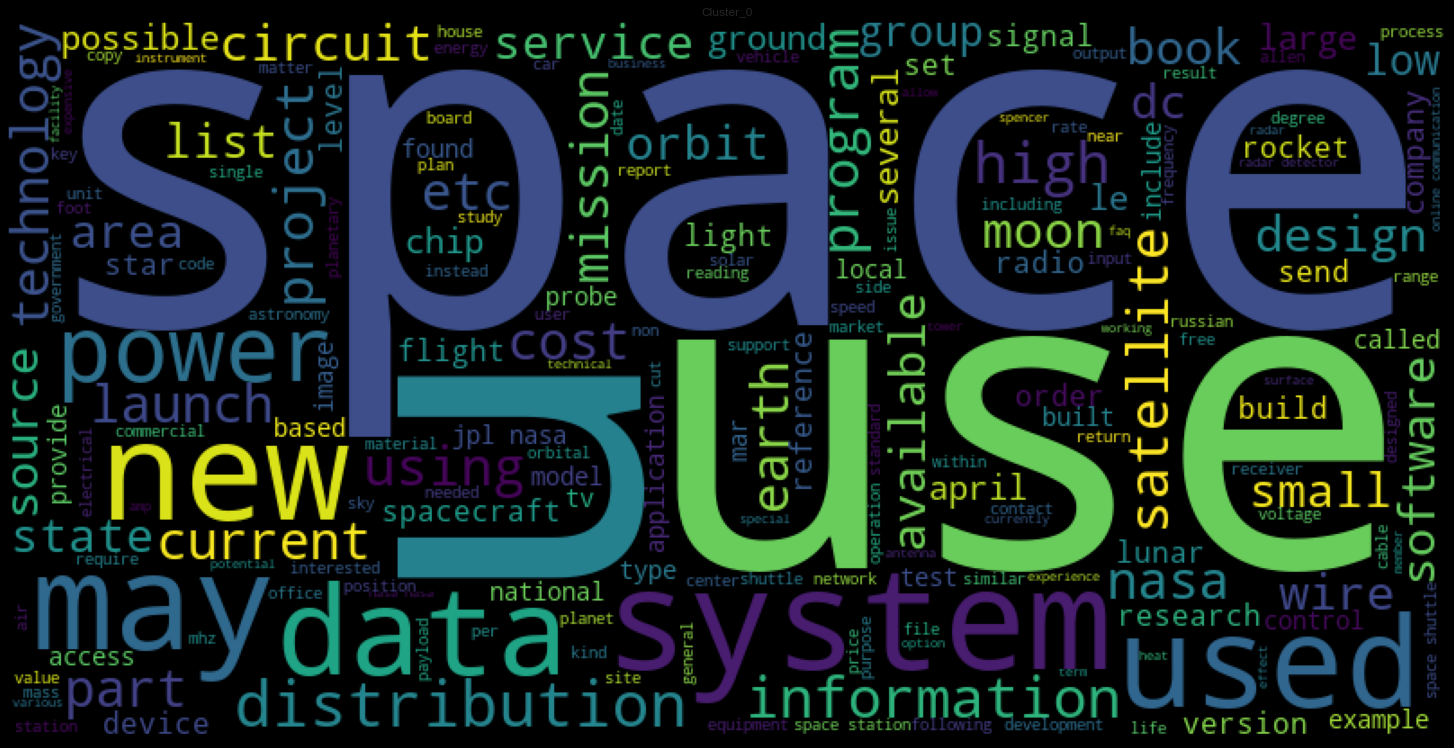

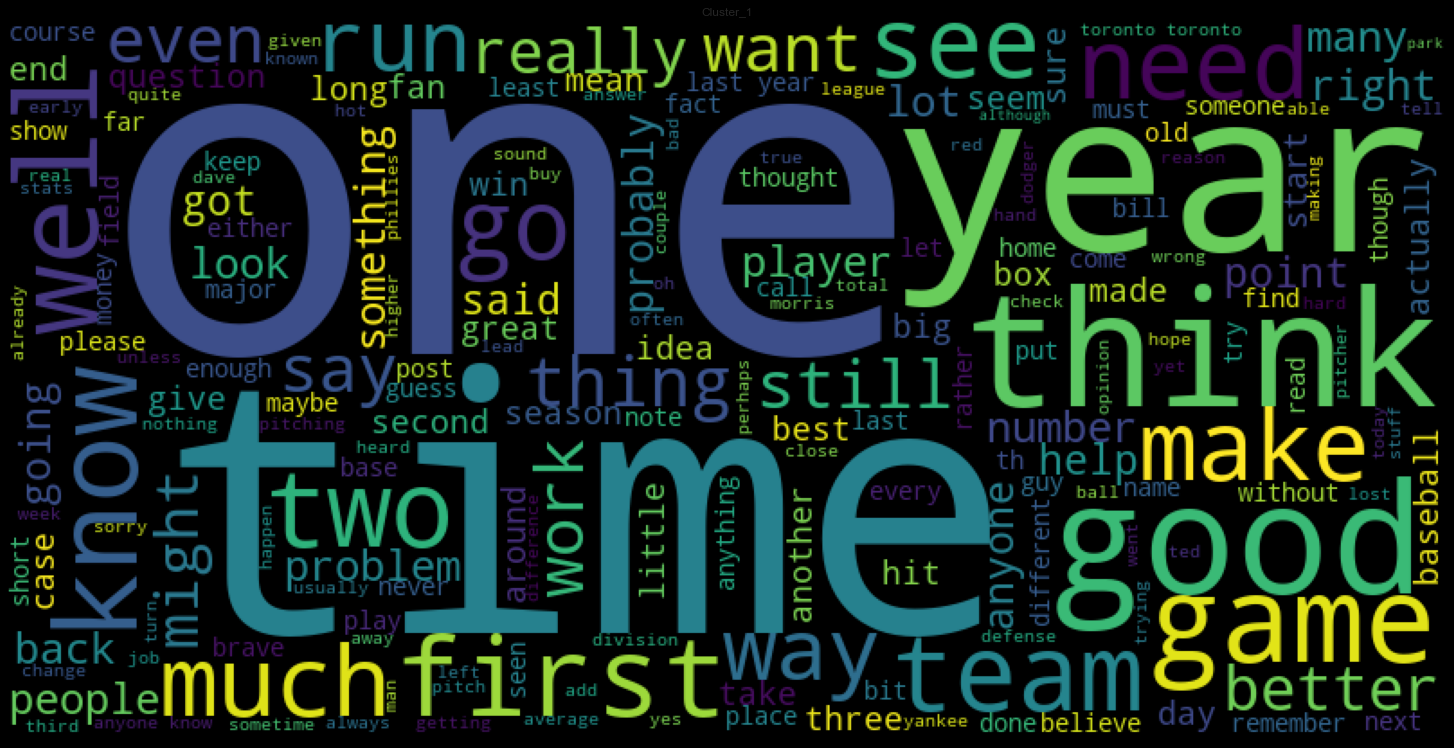

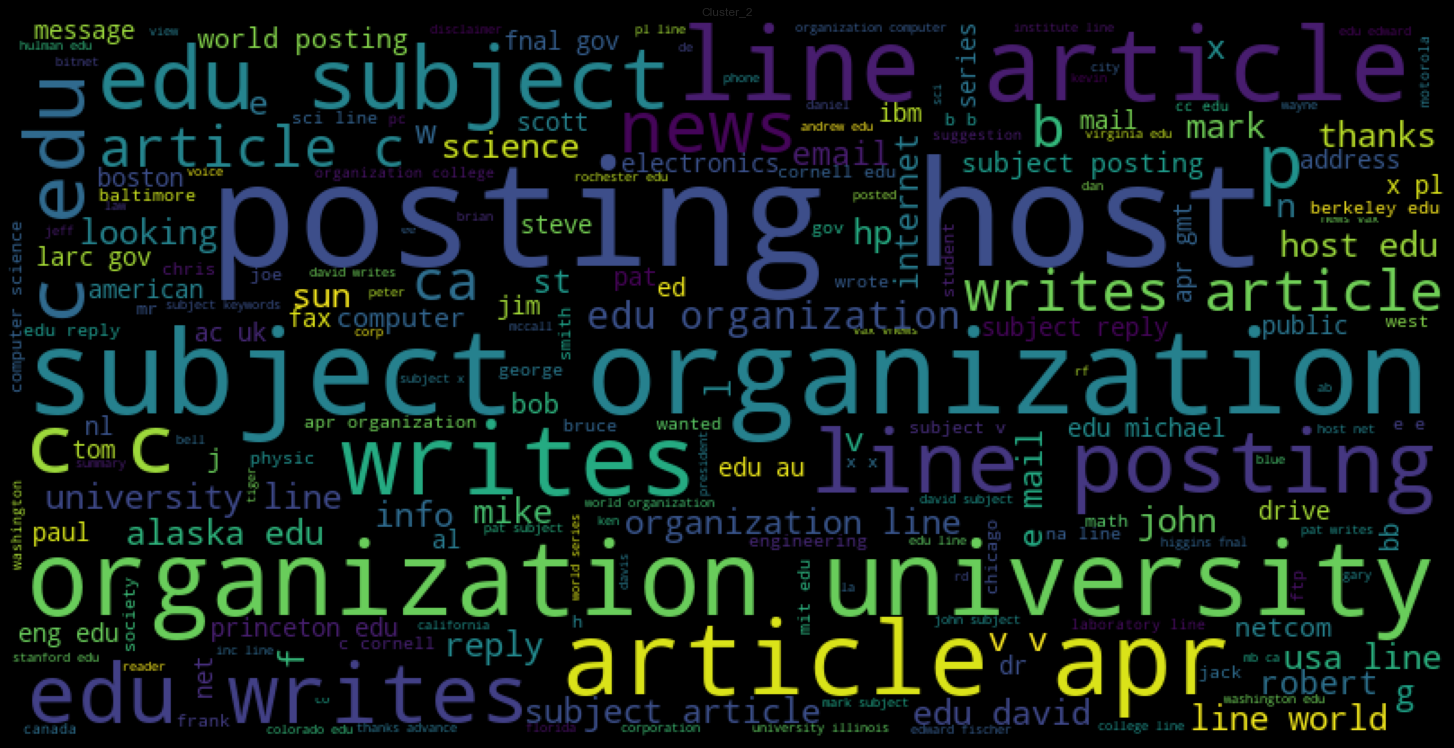

In [182]:
for ind in range(3):
    cluster = [word for i,word in enumerate(corpus) if assigned_clusters[i] == ind]
    print(len(cluster))
    wordcloud_generate(cluster,'Cluster_'+str(ind))

In [126]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
def wordcloud_generate(tweets,heading):
    
    wordcloud = WordCloud(random_state = 2018,width=800, height=400).generate(" ".join(tweets))
    plt.figure( figsize=(20,10),facecolor='k' )
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(heading)